In [1]:
import numpy as np
import extended_cir
import loan_simulation
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
def set_seed_extended_cir(seed=100):
    extended_cir.np.random.seed(seed)


def set_seed_loan_simulation(seed=123):
    loan_simulation.np.random.seed(seed)


def generate_ssrd_model(ir_termS, cr_termS, ir_params, cr_params, ssrd_params):
    ir_model = extended_cir.InterestRateCIRPP(ir_termS, ir_params['k'][0], ir_params['theta'][0], ir_params['sigma'][0],
                                              ir_params['x0'][0])
    cr_model = extended_cir.CreditRiskCIRPP(ir_termS, cr_termS, cr_params['k'][0], cr_params['theta'][0],
                                            cr_params['sigma'][0], cr_params['x0'][0], cr_params['recovery_rate'][0],
                                            cr_params['premium_frequency'][0])
    ssrd = extended_cir.SSRDSimulation(ir_model, cr_model, ssrd_params['rho'], ssrd_params['simulations'],
                                       ssrd_params['time_step'], ssrd_params['T'])
    return ssrd


def simulate_funding_cost(ssrd, liquidity_risk_percent, risk_margin_percent):
    set_seed_extended_cir()
    rt, ct, ft = ssrd.simulateMC()
    ft += liquidity_risk_percent
    ft += risk_margin_percent
    return ft, rt, ct


def plot_funding_cost(ft, rt, ct):
    plt.figure(figsize=(12, 8))
    plt.plot(rt.T)
    plt.xlabel('Months')
    plt.ylabel('Interest Rate')
    plt.title("Interest Rate(Risk Free)")
    plt.savefig('funding_cost_graphs/interest_rate.png')
    plt.show()
    plt.figure(figsize=(12, 8))
    plt.plot(ct.T)
    plt.xlabel('Months')
    plt.ylabel('Hazard Rate')
    plt.title('Hazard Rate')
    plt.savefig('funding_cost_graphs/hazard_rate.png')
    plt.show()
    plt.figure(figsize=(12, 8))
    plt.plot(ft.T)
    plt.xlabel('Months')
    plt.ylabel('Funding Cost')
    plt.title('Funding Cost');
    plt.savefig('funding_cost_graphs/funding_cost.png')
    plt.show()


def simulate_loan_tranches():
    set_seed_loan_simulation()
    loan_sim = loan_simulation.LoanBookSimulation(60, 10 * 1e7, 0.5)
    loan_sim.simulate_loan_book()
    loan_book = loan_sim.loan_book_segmentation();
    tranches = loan_sim.split_loan_into_tranches(loan_book)
    export_loan_tranche_data(tranches)
    return tranches

def export_loan_tranche_data(tranches):
    labels = []
    tranche_loan_tenure = []
    tranche_loan_amounts = []
    tranche_fixed_rates = []
    for key, loan_tranche in tranches.items():
        labels.append(key)
        tranche_loan_amounts.append(sum(loan_tranche['loan_amount']))
        total_loans = len(loan_tranche)
        tranche_fixed_rates.append(sum(loan_tranche['fixed_rate']) / total_loans)
        tranche_loan_tenure.append(int(sum(loan_tranche['loan_term']) / len(loan_tranche)))
    loan_tranche_details = pd.DataFrame({'label': labels, 'tranche_loan_tenure': tranche_loan_tenure, 'tranche_loan_amounts': tranche_loan_amounts, 'tranche_fixed_rates':tranche_fixed_rates})
    with pd.ExcelWriter('loan_tranche_aggregate.xlsx', engine='xlsxwriter') as writer:
        loan_tranche_details.to_excel(writer, index=False)


def yearly_to_monthly_rate(rate):
    return (1 + rate) ** (1 / 12) - 1


def survivorship(loan_rate, interest_rate, h, cric_p=0.33):
    # return loan_rate <= interest_rate
    p = 1 / (1 + np.exp(-h * (interest_rate - loan_rate)))
    return p > cric_p


def calculate_clv(loan_tranche, simulations, max_loan_term, ft, rt, h):
    loan_amount = sum(loan_tranche['loan_amount'])
    total_loans = len(loan_tranche)
    fixed_rate = sum(loan_tranche['fixed_rate']) / total_loans
    loan_term = int(sum(loan_tranche['loan_term']) / total_loans)
    monthly_rate = fixed_rate / 12
    clvs = []
    loan_life = []
    emi = loan_amount * (monthly_rate * (1 + monthly_rate) ** loan_term) / ((1 + monthly_rate) ** loan_term - 1)
    for sim_num in range(simulations):
        clv = np.zeros(max_loan_term)
        last_month = loan_term
        outstanding_principal = loan_amount
        for month in range(1, loan_term + 1):
            monthly_interest = outstanding_principal * monthly_rate
            principal_component = emi - monthly_interest
            outstanding_principal -= principal_component
            funding_cost = 1 + yearly_to_monthly_rate(ft[sim_num, month])
            cf = monthly_interest / (funding_cost ** month)
            if not survivorship(fixed_rate, rt[sim_num, month], h):
                last_month = month
                clv[month - 1:max_loan_term] = clv[month - 2] + 3 * cf
                break
            clv[month - 1:max_loan_term] = clv[month - 2] + cf
        clvs.append(clv / total_loans)
        loan_life.append(last_month)

    return np.array(clvs), np.array(loan_life)


def find_clv(tranches, ft, rt, max_loan_term, h=100):
    tranche_clvs = []
    labels = []
    survived_months = []
    tranche_loan_tenure = []
    for key, loan_tranche in tranches.items():
        clvs, loan_life = calculate_clv(loan_tranche, ssrd_params['simulations'], max_loan_term, ft, rt, h)
        labels.append(key)
        tranche_clvs.append(clvs.mean(axis=0))
        survived_months.append(loan_life.mean())
        tranche_loan_tenure.append(int(sum(loan_tranche['loan_term']) / len(loan_tranche)))
    tranche_clvs = np.array(tranche_clvs)
    labels = np.array(labels)

    clv_table = pd.DataFrame({'label': labels, 'clv': tranche_clvs.T[:][-1], 'survived_months': survived_months, 'tranche_loan_tenure': tranche_loan_tenure})
    return labels, tranche_clvs, clv_table


def plot_clv(labels, clvs, max_loan_term, top_tranches_to_disply, image_name):
    # return
    high_clv_indices = sorted_indexes_desc(clvs[:, max_loan_term - 1])
    plt.figure(figsize=(12, 8))
    plt.plot(clvs[high_clv_indices[:top_tranches_to_disply]].T,
             label=labels[high_clv_indices[:top_tranches_to_disply]]);
    plt.xlabel('Months')
    plt.ylabel('CLV(£)')
    plt.title('Evolution of CLV for each Tranche over 60 months');
    leg_title = "Legend(Amount, Term, Fixed Rate)"
    leg = plt.legend(title=leg_title)  #, loc='upper left', bbox_to_anchor=(1, 1))
    plt.setp(leg.get_title(), weight='bold')
    plt.savefig(f'clv_graphs/{image_name}.png')
    plt.show()

def sorted_indexes_desc(clvs):
    high_clv_indices = np.argsort(clvs)
    return high_clv_indices[::-1]

def display_clv(clvs_df):
    high_clv_indices = sorted_indexes_desc(np.array(clvs_df['clv']))
    print(clvs_df.iloc[high_clv_indices].to_string(index=False))

# def write_clv_to_excel(clvs, sheet_names):
#     with pd.ExcelWriter('clv_result.xlsx', engine='xlsxwriter') as writer:
#         for clv_table, sheet_name in zip(clvs, sheet_names):
#             high_clv_indices = sorted_indexes_desc(np.array(clv_table['clv']))
#             clv_table.iloc[high_clv_indices].to_excel(writer, sheet_name=sheet_name, index=False)

def next_excel_column(s):
    length = len(s)
    if length == 0:
        return "A"
    if s[-1] != "Z":
        return s[:-1] + chr(ord(s[-1]) + 1)
    return next_excel_column(s[:-1]) + "A"

def write_clv_to_excel(clvs, sheet_names):
    column_no = 0
    sheet_name = 'Sheet1'
    col = 'A'
    col_increments = clvs[-1].shape[1] + 1
    with pd.ExcelWriter('clv_result.xlsx', engine='xlsxwriter') as writer:
        for clv_table, _column_title in zip(clvs, sheet_names):
            high_clv_indices = sorted_indexes_desc(np.array(clv_table['clv']))
            clv_table.iloc[high_clv_indices].to_excel(writer, startrow=1, startcol=column_no, sheet_name=sheet_name, index=False)
            column_no += col_increments

        workbook  = writer.book
        bold_format = workbook.add_format({'bold': True, 'align': 'center'})
        worksheet = writer.sheets[sheet_name]
        for _clv_table, column_title in zip(clvs, sheet_names):
            next_col = col
            for _i in range(col_increments-2):
                next_col = next_excel_column(next_col)
            worksheet.merge_range(f'{col}1:{next_col}1', column_title, bold_format)
            col = next_excel_column(next_excel_column(next_col))

### Simulate Funding Cost Using SSRD Model

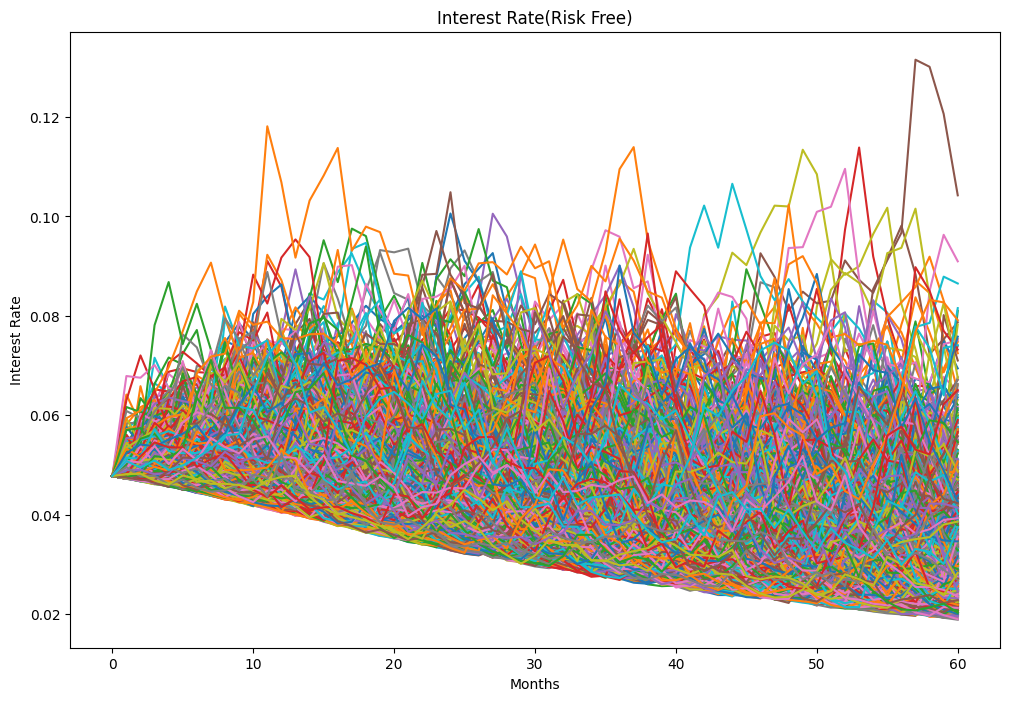

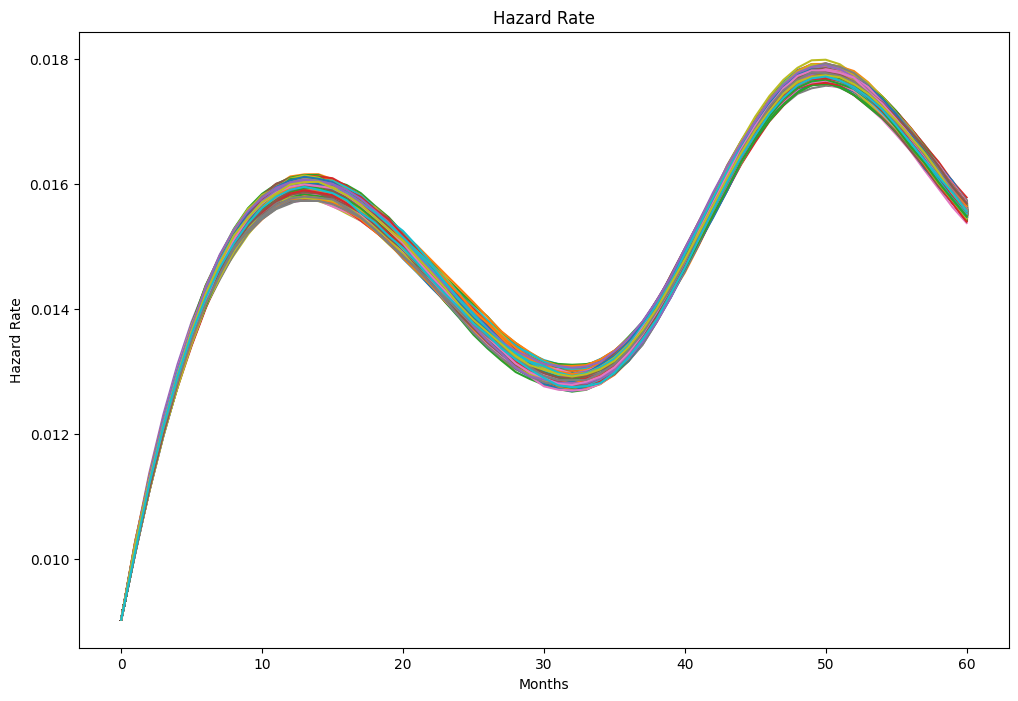

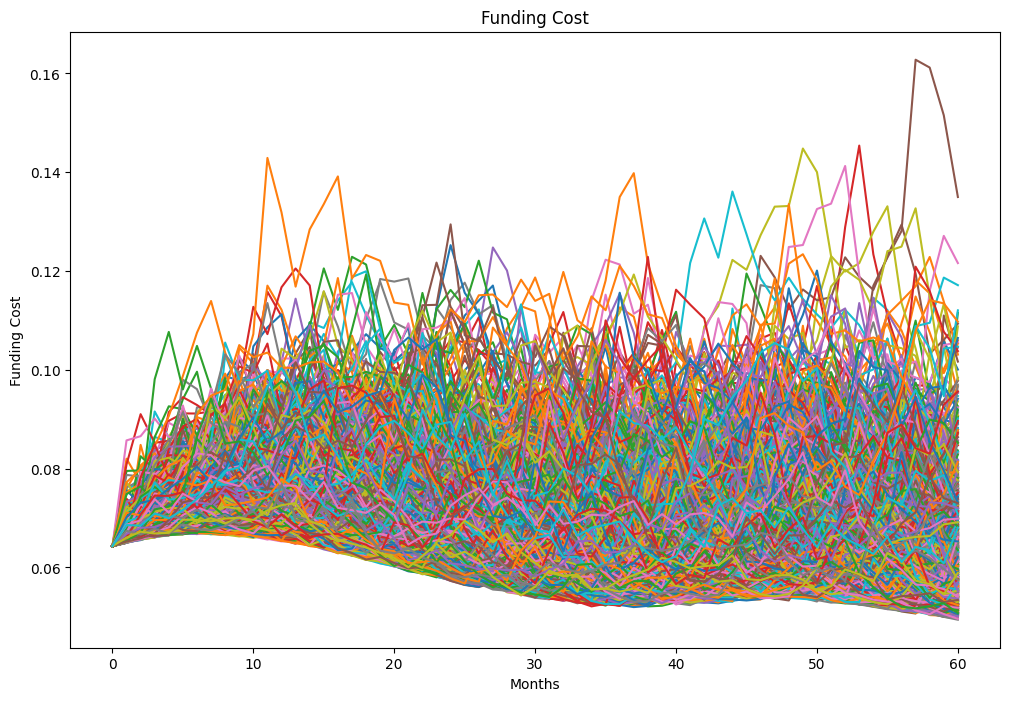

In [3]:
file_path = "data.xlsx"
ir_termS = pd.read_excel(file_path, sheet_name='interest_rate_term_structure')
cr_termS = pd.read_excel(file_path, sheet_name='credit_risk_term_structure')
ir_params = pd.read_excel(file_path, sheet_name='interest_rate_parameters')
cr_params = pd.read_excel(file_path, sheet_name='credit_risk_parameters')
liquidity_risk_bps = np.linspace(0.0025, 0.01, 61)
risk_margin_bps = 0.005
max_loan_tenure = 60
top_tranche_clv_to_display = 10
clv_tables = []
clv_sheet_names = []
ssrd_params = {'simulations': 1000, 'time_step': 1 / 12, 'T': 5, 'rho': 0.3}
ssrd = generate_ssrd_model(ir_termS, cr_termS, ir_params, cr_params, ssrd_params)
funding_cost, risk_free_rate, credit_premia = simulate_funding_cost(ssrd, liquidity_risk_bps, risk_margin_bps)
plot_funding_cost(funding_cost, risk_free_rate, credit_premia)

### Find CLV under normal condition

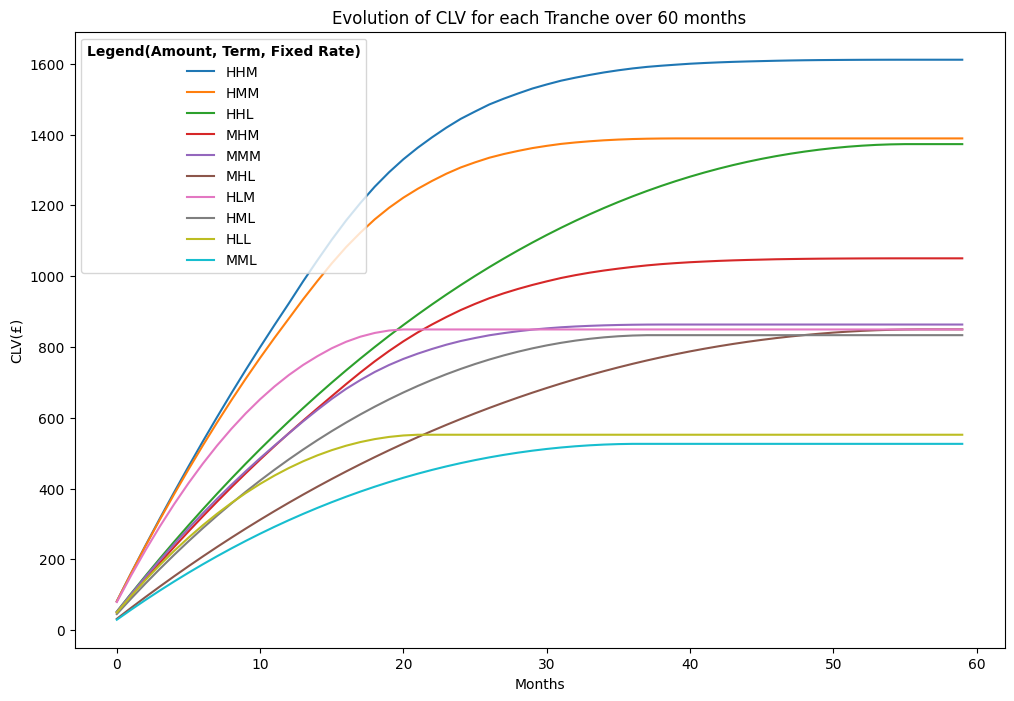

label         clv  survived_months  tranche_loan_tenure
  HHM 1611.396222           26.941                   56
  HMM 1389.064796           26.118                   40
  HHL 1372.948143           55.758                   56
  MHM 1050.265852           30.937                   56
  MMM  863.248337           25.672                   39
  MHL  849.605107           56.512                   57
  HLM  849.355368           20.473                   21
  HML  833.207195           38.000                   38
  HLL  551.899165           22.000                   22
  MML  526.143404           37.000                   37
  MLM  488.199224           19.540                   20
  LHM  421.843291           26.472                   55
  HHH  360.139881            1.012                   55
  HMH  355.155646            1.012                   40
  HLH  352.902568            1.011                   21
  LMM  342.675852           26.580                   39
  MLL  314.218163           20.000              

In [4]:
loan_tranches = simulate_loan_tranches()
clv_labels, trancheClvs, clv_for_excel = find_clv(loan_tranches, funding_cost, risk_free_rate, max_loan_tenure)
clv_tables.append(clv_for_excel)
clv_sheet_names.append('base')
plot_clv(clv_labels, trancheClvs, max_loan_tenure, top_tranche_clv_to_display, 'base');
display_clv(clv_for_excel)

### Under Interest rate 1.1 Vol Stress

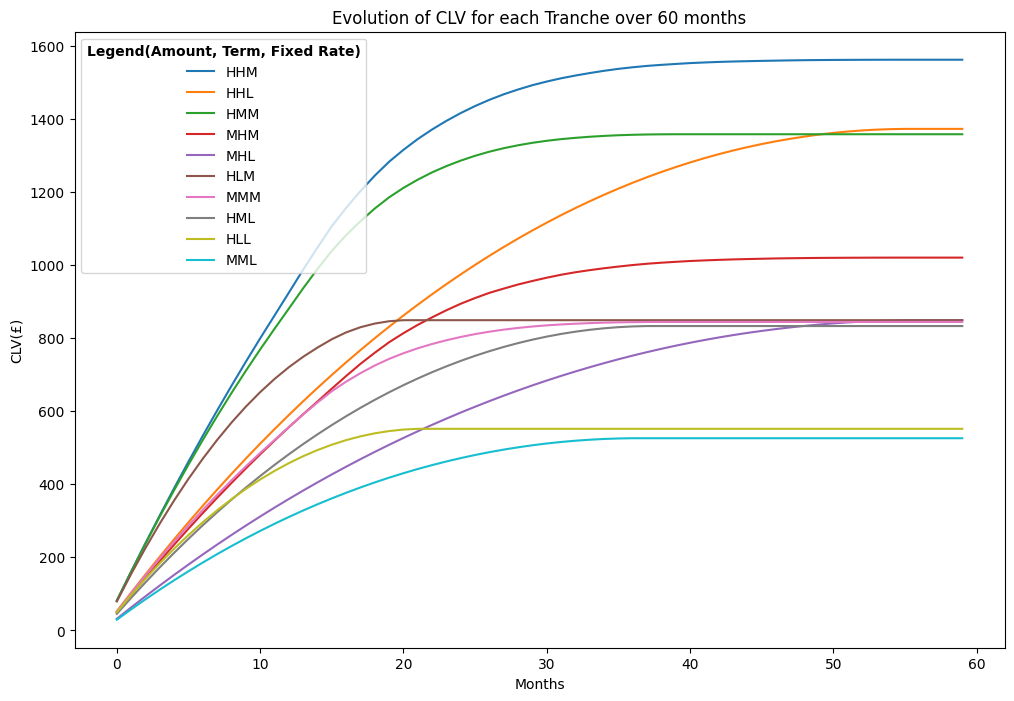

label         clv  survived_months  tranche_loan_tenure
  HHM 1562.387522           25.592                   56
  HHL 1373.038365           55.601                   56
  HMM 1358.390673           24.909                   40
  MHM 1020.633549           29.406                   56
  MHL  849.503929           56.236                   57
  HLM  849.323803           20.213                   21
  MMM  844.498069           24.517                   39
  HML  833.263221           38.000                   38
  HLL  551.918997           22.000                   22
  MML  526.177893           37.000                   37
  MLM  488.230615           19.323                   20
  LHM  408.895400           25.134                   55
  HHH  362.363646            1.035                   55
  HMH  355.845791            1.020                   40
  HLH  353.495531            1.020                   21
  LMM  335.359850           25.319                   39
  MLL  314.228109           20.000              

In [5]:
file_path = "data.xlsx"
ir_termS = pd.read_excel(file_path, sheet_name='interest_rate_term_structure')
cr_termS = pd.read_excel(file_path, sheet_name='credit_risk_term_structure')
ir_params = pd.read_excel(file_path, sheet_name='interest_rate_parameters')
cr_params = pd.read_excel(file_path, sheet_name='credit_risk_parameters')
ir_params['sigma'] *= 1.1
ssrd = generate_ssrd_model(ir_termS, cr_termS, ir_params, cr_params, ssrd_params)
funding_cost, risk_free_rate, credit_premia = simulate_funding_cost(ssrd, liquidity_risk_bps, risk_margin_bps)
clv_labels, trancheClvs, clv_for_excel = find_clv(loan_tranches, funding_cost, risk_free_rate, max_loan_tenure)
clv_tables.append(clv_for_excel)
clv_sheet_names.append('interest_vol_1_1')
plot_clv(clv_labels, trancheClvs, max_loan_tenure, top_tranche_clv_to_display, 'interest_vol_1_1');
display_clv(clv_for_excel)

### Under 0.9 interest rate vol stress

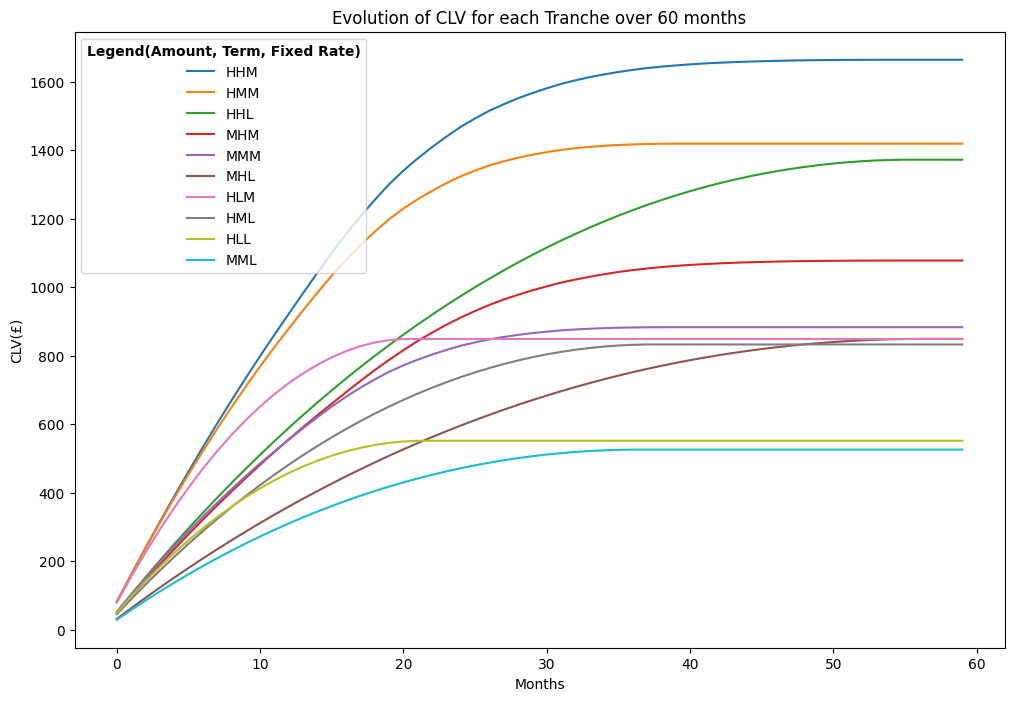

label         clv  survived_months  tranche_loan_tenure
  HHM 1664.791029           28.467                   56
  HMM 1419.599593           27.421                   40
  HHL 1372.808682           55.884                   56
  MHM 1078.375972           32.466                   56
  MMM  883.570854           27.065                   39
  MHL  849.594828           56.715                   57
  HLM  848.987604           20.671                   21
  HML  833.157636           38.000                   38
  HLL  551.881313           22.000                   22
  MML  526.112872           37.000                   37
  MLM  487.866212           19.720                   20
  LHM  436.265429           28.018                   55
  HHH  359.598064            1.007                   55
  HMH  354.529813            1.006                   40
  HLH  352.442233            1.006                   21
  LMM  349.367010           27.777                   39
  MLL  314.209234           20.000              

In [6]:
file_path = "data.xlsx"
ir_termS = pd.read_excel(file_path, sheet_name='interest_rate_term_structure')
cr_termS = pd.read_excel(file_path, sheet_name='credit_risk_term_structure')
ir_params = pd.read_excel(file_path, sheet_name='interest_rate_parameters')
cr_params = pd.read_excel(file_path, sheet_name='credit_risk_parameters')
ir_params['sigma'] *= 0.9
ssrd = generate_ssrd_model(ir_termS, cr_termS, ir_params, cr_params, ssrd_params)
funding_cost, risk_free_rate, credit_premia = simulate_funding_cost(ssrd, liquidity_risk_bps, risk_margin_bps)
clv_labels, trancheClvs, clv_for_excel = find_clv(loan_tranches, funding_cost, risk_free_rate, max_loan_tenure)
clv_tables.append(clv_for_excel)
clv_sheet_names.append('interest_vol_0_9')
plot_clv(clv_labels, trancheClvs, max_loan_tenure, top_tranche_clv_to_display, 'interest_vol_0_9');
display_clv(clv_for_excel)

### Under credit risk 1.1 vol stress

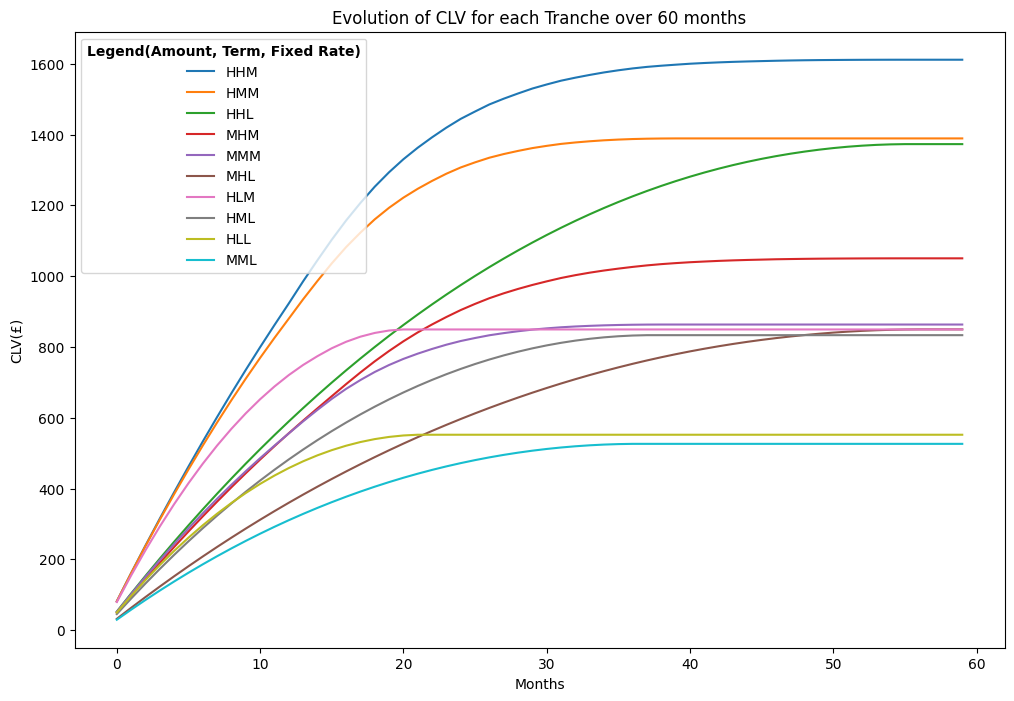

label         clv  survived_months  tranche_loan_tenure
  HHM 1611.395025           26.941                   56
  HMM 1389.064161           26.118                   40
  HHL 1372.948101           55.758                   56
  MHM 1050.265075           30.937                   56
  MMM  863.247951           25.672                   39
  MHL  849.605080           56.512                   57
  HLM  849.355366           20.473                   21
  HML  833.207175           38.000                   38
  HLL  551.899161           22.000                   22
  MML  526.143391           37.000                   37
  MLM  488.199225           19.540                   20
  LHM  421.842976           26.472                   55
  HHH  360.139881            1.012                   55
  HMH  355.155645            1.012                   40
  HLH  352.902568            1.011                   21
  LMM  342.675699           26.580                   39
  MLL  314.218162           20.000              

In [7]:
file_path = "data.xlsx"
ir_termS = pd.read_excel(file_path, sheet_name='interest_rate_term_structure')
cr_termS = pd.read_excel(file_path, sheet_name='credit_risk_term_structure')
ir_params = pd.read_excel(file_path, sheet_name='interest_rate_parameters')
cr_params = pd.read_excel(file_path, sheet_name='credit_risk_parameters')
cr_params['sigma'] *= 1.1
ssrd = generate_ssrd_model(ir_termS, cr_termS, ir_params, cr_params, ssrd_params)
funding_cost, risk_free_rate, credit_premia = simulate_funding_cost(ssrd, liquidity_risk_bps, risk_margin_bps)
clv_labels, trancheClvs, clv_for_excel = find_clv(loan_tranches, funding_cost, risk_free_rate, max_loan_tenure)
clv_tables.append(clv_for_excel)
clv_sheet_names.append('credit_vol_1_1')
plot_clv(clv_labels, trancheClvs, max_loan_tenure, top_tranche_clv_to_display, 'credit_vol_1_1');
display_clv(clv_for_excel)

### Under credit risk 0.9 vol stress

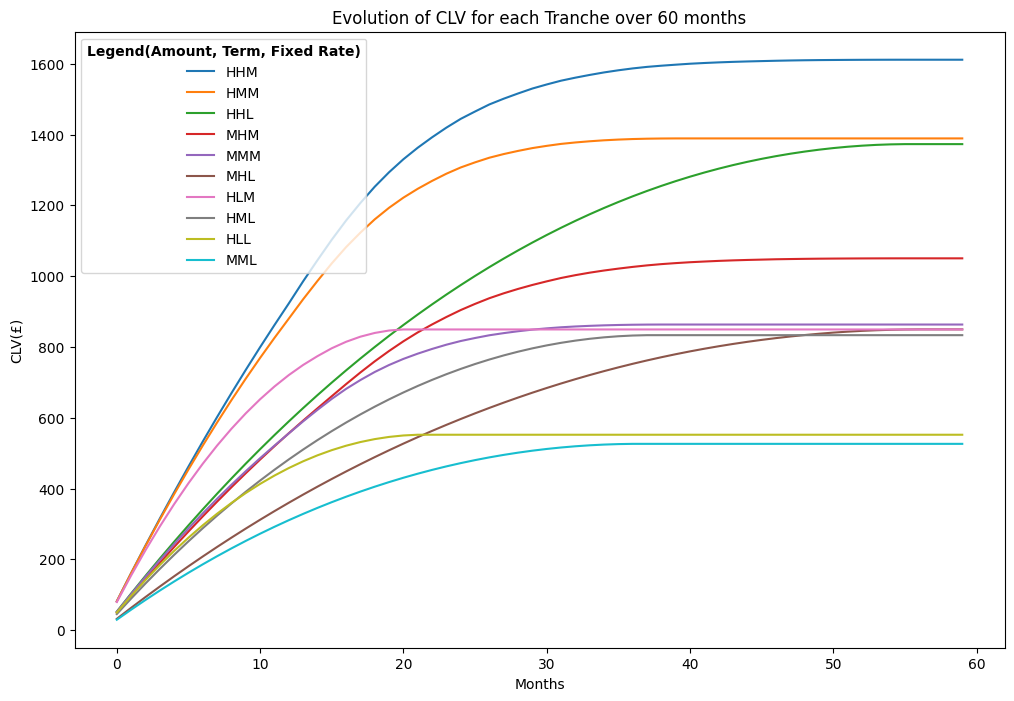

label         clv  survived_months  tranche_loan_tenure
  HHM 1611.397422           26.941                   56
  HMM 1389.065433           26.118                   40
  HHL 1372.948188           55.758                   56
  MHM 1050.266630           30.937                   56
  MMM  863.248724           25.672                   39
  MHL  849.605136           56.512                   57
  HLM  849.355370           20.473                   21
  HML  833.207216           38.000                   38
  HLL  551.899168           22.000                   22
  MML  526.143417           37.000                   37
  MLM  488.199223           19.540                   20
  LHM  421.843606           26.472                   55
  HHH  360.139882            1.012                   55
  HMH  355.155647            1.012                   40
  HLH  352.902569            1.011                   21
  LMM  342.676006           26.580                   39
  MLL  314.218166           20.000              

In [8]:
file_path = "data.xlsx"
ir_termS = pd.read_excel(file_path, sheet_name='interest_rate_term_structure')
cr_termS = pd.read_excel(file_path, sheet_name='credit_risk_term_structure')
ir_params = pd.read_excel(file_path, sheet_name='interest_rate_parameters')
cr_params = pd.read_excel(file_path, sheet_name='credit_risk_parameters')
cr_params['sigma'] *= 0.9
ssrd = generate_ssrd_model(ir_termS, cr_termS, ir_params, cr_params, ssrd_params)
funding_cost, risk_free_rate, credit_premia = simulate_funding_cost(ssrd, liquidity_risk_bps, risk_margin_bps)
clv_labels, trancheClvs, clv_for_excel = find_clv(loan_tranches, funding_cost, risk_free_rate, max_loan_tenure)
clv_tables.append(clv_for_excel)
clv_sheet_names.append('credit_vol_0_9')
plot_clv(clv_labels, trancheClvs, max_loan_tenure, top_tranche_clv_to_display, 'credit_vol_0_9');
display_clv(clv_for_excel)

### Under interest rate parallel shift stress +10 bps

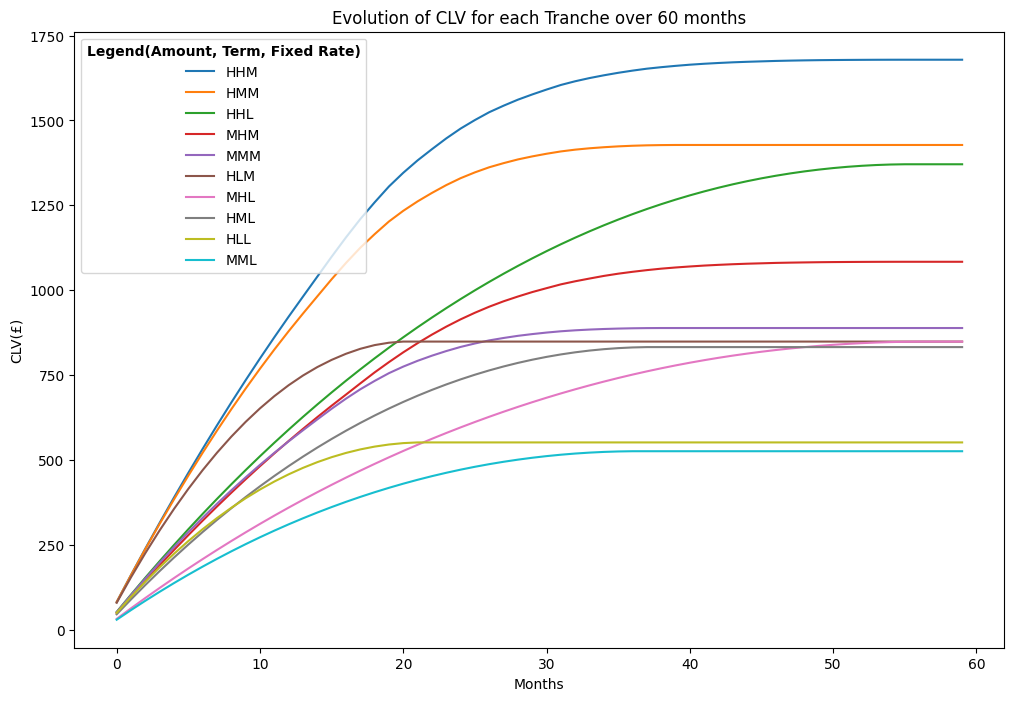

label         clv  survived_months  tranche_loan_tenure
  HHM 1678.883756           28.979                   56
  HMM 1427.739985           27.817                   40
  HHL 1370.920860           55.958                   56
  MHM 1083.688743           32.902                   56
  MMM  888.538111           27.436                   39
  HLM  848.612421           20.778                   21
  MHL  848.455274           56.844                   57
  HML  832.367525           38.000                   38
  HLL  551.562440           22.000                   22
  MML  525.626143           37.000                   37
  MLM  487.603583           19.792                   20
  LHM  440.386475           28.555                   55
  HHH  360.871837            1.020                   55
  HMH  355.819438            1.020                   40
  HLH  352.973866            1.012                   21
  LMM  351.395200           28.241                   39
  MLL  314.042183           20.000              

In [9]:
file_path = "data.xlsx"
ir_termS = pd.read_excel(file_path, sheet_name='interest_rate_term_structure')
cr_termS = pd.read_excel(file_path, sheet_name='credit_risk_term_structure')
ir_params = pd.read_excel(file_path, sheet_name='interest_rate_parameters')
cr_params = pd.read_excel(file_path, sheet_name='credit_risk_parameters')
ir_termS['rate'] += 0.001
ssrd = generate_ssrd_model(ir_termS, cr_termS, ir_params, cr_params, ssrd_params)
funding_cost, risk_free_rate, credit_premia = simulate_funding_cost(ssrd, liquidity_risk_bps, risk_margin_bps)
clv_labels, trancheClvs, clv_for_excel = find_clv(loan_tranches, funding_cost, risk_free_rate, max_loan_tenure)
clv_tables.append(clv_for_excel)
clv_sheet_names.append('interst_yield_curve_inc_10bps')
plot_clv(clv_labels, trancheClvs, max_loan_tenure, top_tranche_clv_to_display, 'interst_yield_curve_inc_10bps');
display_clv(clv_for_excel)

### Under interest rate parallel shift stress -10 bps

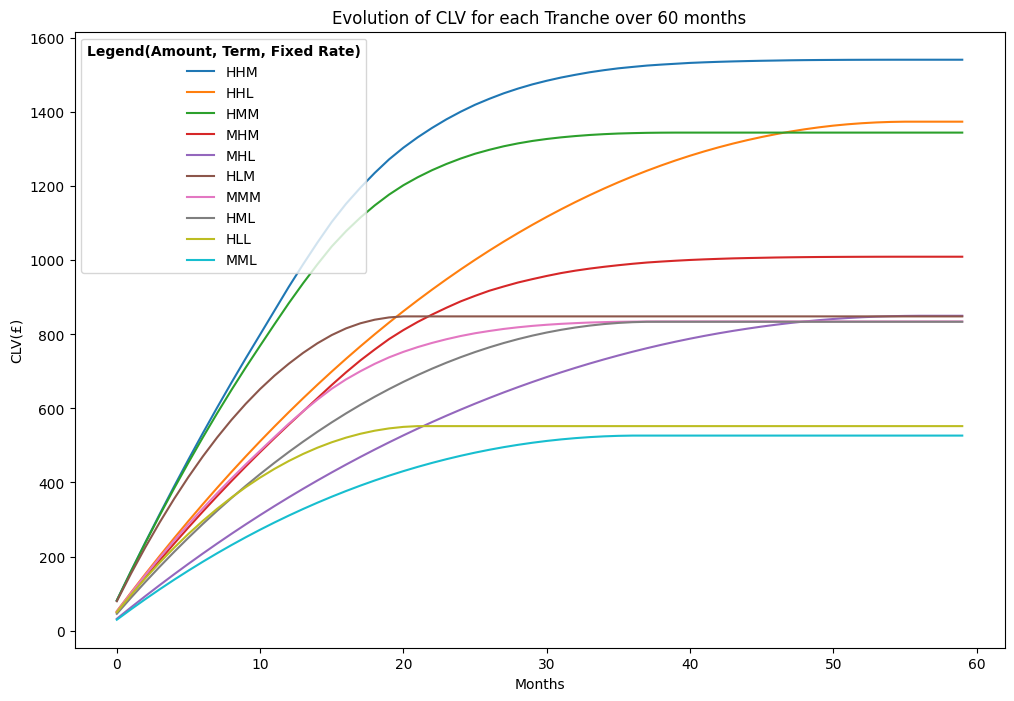

label         clv  survived_months  tranche_loan_tenure
  HHM 1541.931075           25.011                   56
  HHL 1374.585225           55.395                   56
  HMM 1345.071224           24.429                   40
  MHM 1009.822302           28.795                   56
  MHL  850.290613           55.989                   57
  HLM  848.623585           20.033                   21
  MMM  834.959549           23.973                   39
  HML  834.048910           38.000                   38
  HLL  552.236502           22.000                   22
  MML  526.661904           37.000                   37
  MLM  487.883063           19.109                   20
  LHM  403.236938           24.553                   55
  HHH  360.056779            1.011                   55
  HMH  355.076050            1.011                   40
  HLH  352.930517            1.011                   21
  LMM  331.891991           24.763                   39
  MLL  314.394451           20.000              

In [10]:
file_path = "data.xlsx"
ir_termS = pd.read_excel(file_path, sheet_name='interest_rate_term_structure')
cr_termS = pd.read_excel(file_path, sheet_name='credit_risk_term_structure')
ir_params = pd.read_excel(file_path, sheet_name='interest_rate_parameters')
cr_params = pd.read_excel(file_path, sheet_name='credit_risk_parameters')
ir_termS['rate'] -= 0.001
ssrd = generate_ssrd_model(ir_termS, cr_termS, ir_params, cr_params, ssrd_params)
funding_cost, risk_free_rate, credit_premia = simulate_funding_cost(ssrd, liquidity_risk_bps, risk_margin_bps)
clv_labels, trancheClvs, clv_for_excel = find_clv(loan_tranches, funding_cost, risk_free_rate, max_loan_tenure)
clv_tables.append(clv_for_excel)
clv_sheet_names.append('interst_yield_curve_dec_10bps')
plot_clv(clv_labels, trancheClvs, max_loan_tenure, top_tranche_clv_to_display, 'interst_yield_curve_dec_10bps');
display_clv(clv_for_excel)

### Under credit spread parallel shift stress +10 bps

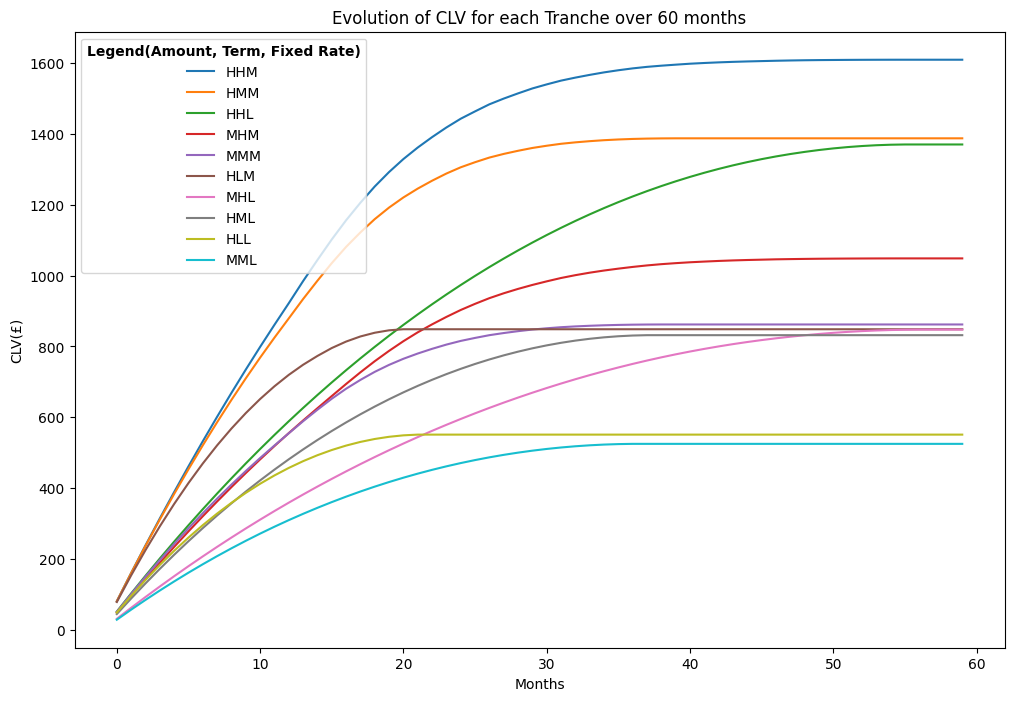

label         clv  survived_months  tranche_loan_tenure
  HHM 1608.669864           26.941                   56
  HMM 1386.999244           26.118                   40
  HHL 1369.633029           55.758                   56
  MHM 1048.331665           30.937                   56
  MMM  861.988615           25.672                   39
  HLM  848.524134           20.473                   21
  MHL  847.519606           56.512                   57
  HML  831.808866           38.000                   38
  HLL  551.338293           22.000                   22
  MML  525.281983           37.000                   37
  MLM  487.741502           19.540                   20
  LHM  421.140666           26.472                   55
  HHH  360.092265            1.012                   55
  HMH  355.108712            1.012                   40
  HLH  352.856050            1.011                   21
  LMM  342.166904           26.580                   39
  MLL  313.925031           20.000              

In [11]:
file_path = "data.xlsx"
ir_termS = pd.read_excel(file_path, sheet_name='interest_rate_term_structure')
cr_termS = pd.read_excel(file_path, sheet_name='credit_risk_term_structure')
ir_params = pd.read_excel(file_path, sheet_name='interest_rate_parameters')
cr_params = pd.read_excel(file_path, sheet_name='credit_risk_parameters')
cr_termS['spread'] += 0.001
ssrd = generate_ssrd_model(ir_termS, cr_termS, ir_params, cr_params, ssrd_params)
funding_cost, risk_free_rate, credit_premia = simulate_funding_cost(ssrd, liquidity_risk_bps, risk_margin_bps)
clv_labels, trancheClvs, clv_for_excel = find_clv(loan_tranches, funding_cost, risk_free_rate, max_loan_tenure)
clv_tables.append(clv_for_excel)
clv_sheet_names.append('credit_yield_curve_inc_10bps')
plot_clv(clv_labels, trancheClvs, max_loan_tenure, top_tranche_clv_to_display, 'credit_yield_curve_inc_10bps');
display_clv(clv_for_excel)

### Under credit spread parallel shift stress -10 bps

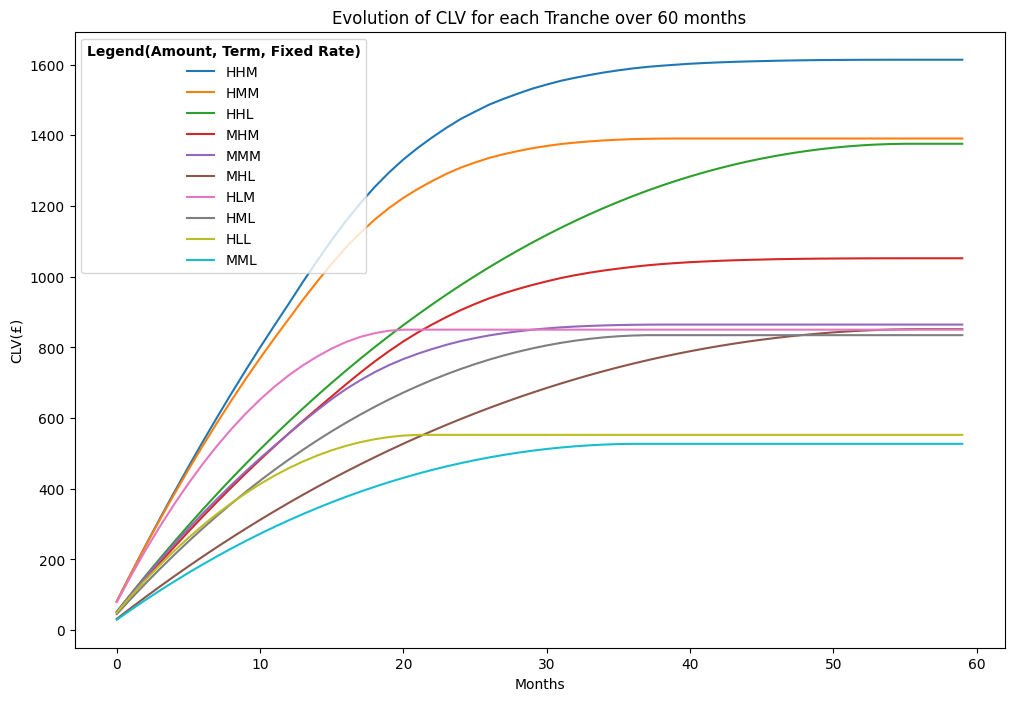

label         clv  survived_months  tranche_loan_tenure
  HHM 1614.133719           26.941                   56
  HMM 1391.138080           26.118                   40
  HHL 1376.280515           55.758                   56
  MHM 1052.208345           30.937                   56
  MMM  864.512721           25.672                   39
  MHL  851.701594           56.512                   57
  HLM  850.189069           20.473                   21
  HML  834.611193           38.000                   38
  HLL  552.461735           22.000                   22
  MML  527.008262           37.000                   37
  MLM  488.658277           19.540                   20
  LHM  422.548759           26.472                   55
  HHH  360.187581            1.012                   55
  HMH  355.202662            1.012                   40
  HLH  352.949167            1.011                   21
  LMM  343.186703           26.580                   39
  MLL  314.512147           20.000              

In [12]:
file_path = "data.xlsx"
ir_termS = pd.read_excel(file_path, sheet_name='interest_rate_term_structure')
cr_termS = pd.read_excel(file_path, sheet_name='credit_risk_term_structure')
ir_params = pd.read_excel(file_path, sheet_name='interest_rate_parameters')
cr_params = pd.read_excel(file_path, sheet_name='credit_risk_parameters')
cr_termS['spread'] -= 0.001
ssrd = generate_ssrd_model(ir_termS, cr_termS, ir_params, cr_params, ssrd_params)
funding_cost, risk_free_rate, credit_premia = simulate_funding_cost(ssrd, liquidity_risk_bps, risk_margin_bps)
clv_labels, trancheClvs, clv_for_excel = find_clv(loan_tranches, funding_cost, risk_free_rate, max_loan_tenure)
clv_tables.append(clv_for_excel)
clv_sheet_names.append('credit_yield_curve_dec_10bps')
plot_clv(clv_labels, trancheClvs, max_loan_tenure, top_tranche_clv_to_display, 'credit_yield_curve_dec_10bps');
display_clv(clv_for_excel)

### Under Normal yield curve(upward curve)

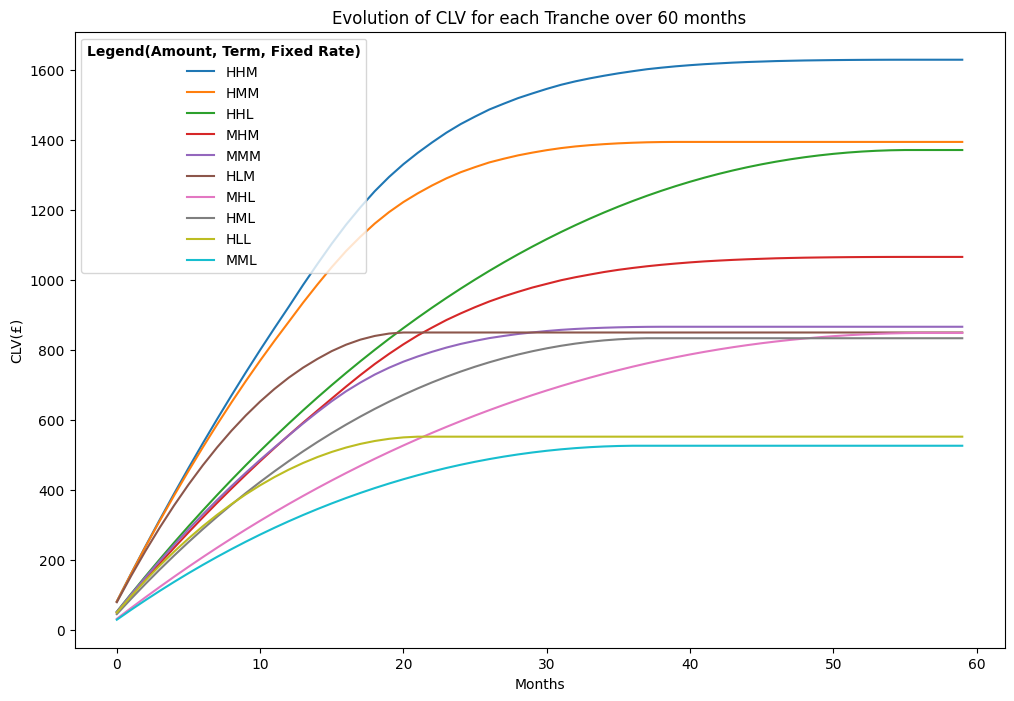

label         clv  survived_months  tranche_loan_tenure
  HHM 1628.067815           27.862                   56
  HMM 1393.388978           26.610                   40
  HHL 1370.272395           56.000                   56
  MHM 1065.086979           32.383                   56
  MMM  865.668003           26.134                   39
  HLM  849.307318           20.479                   21
  MHL  847.958646           57.000                   57
  HML  832.912448           38.000                   38
  HLL  551.896736           22.000                   22
  MML  525.981527           37.000                   37
  MLM  488.187537           19.541                   20
  LHM  425.574887           27.281                   55
  HHH  360.139798            1.012                   55
  HMH  355.155564            1.012                   40
  HLH  352.902487            1.011                   21
  LMM  343.695320           27.022                   39
  MLL  314.217854           20.000              

In [13]:
file_path = "data.xlsx"
ir_termS = pd.read_excel(file_path, sheet_name='interest_rate_term_structure')
cr_termS = pd.read_excel(file_path, sheet_name='credit_risk_term_structure')
ir_params = pd.read_excel(file_path, sheet_name='interest_rate_parameters')
cr_params = pd.read_excel(file_path, sheet_name='credit_risk_parameters')
max_index = np.argmax(ir_termS['rate'])
ir_termS.loc[max_index:, 'rate'] = ir_termS['rate'][max_index]
ssrd = generate_ssrd_model(ir_termS, cr_termS, ir_params, cr_params, ssrd_params)
funding_cost, risk_free_rate, credit_premia = simulate_funding_cost(ssrd, liquidity_risk_bps, risk_margin_bps)
clv_labels, trancheClvs, clv_for_excel = find_clv(loan_tranches, funding_cost, risk_free_rate, max_loan_tenure)
clv_tables.append(clv_for_excel)
clv_sheet_names.append('interest_rate_upward_curve')
plot_clv(clv_labels, trancheClvs, max_loan_tenure, top_tranche_clv_to_display, 'interest_rate_upward_curve');
display_clv(clv_for_excel)

### Under less stress on initial curve and more on the end

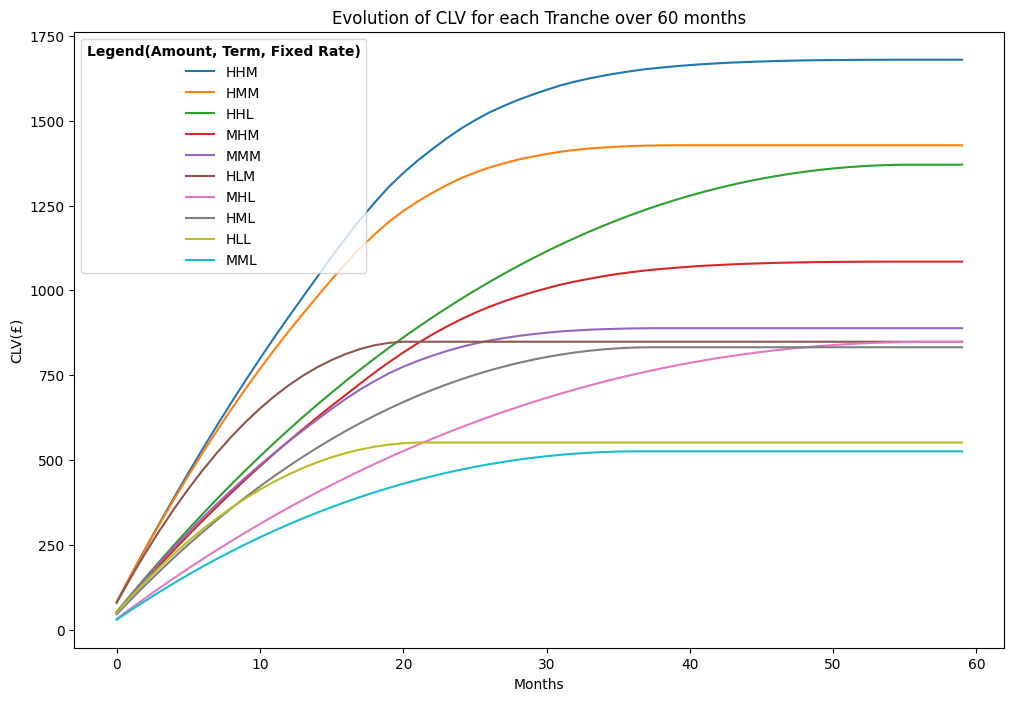

label         clv  survived_months  tranche_loan_tenure
  HHM 1679.816547           29.081                   56
  HMM 1427.706758           27.822                   40
  HHL 1370.388551           55.999                   56
  MHM 1084.795816           33.114                   56
  MMM  888.530492           27.436                   39
  HLM  848.612311           20.778                   21
  MHL  848.108408           56.983                   57
  HML  832.367690           38.000                   38
  HLL  551.562362           22.000                   22
  MML  525.626238           37.000                   37
  MLM  487.603528           19.792                   20
  LHM  440.516087           28.629                   55
  HHH  360.871785            1.020                   55
  HMH  355.819387            1.020                   40
  HLH  352.973816            1.012                   21
  LMM  351.388556           28.241                   39
  MLL  314.042147           20.000              

In [14]:
file_path = "data.xlsx"
ir_termS = pd.read_excel(file_path, sheet_name='interest_rate_term_structure')
cr_termS = pd.read_excel(file_path, sheet_name='credit_risk_term_structure')
ir_params = pd.read_excel(file_path, sheet_name='interest_rate_parameters')
cr_params = pd.read_excel(file_path, sheet_name='credit_risk_parameters')
ir_termS['rate'] += 0.001
ir_termS.loc[len(ir_termS)/2:, 'rate'] += 0.001
ssrd = generate_ssrd_model(ir_termS, cr_termS, ir_params, cr_params, ssrd_params)
funding_cost, risk_free_rate, credit_premia = simulate_funding_cost(ssrd, liquidity_risk_bps, risk_margin_bps)
clv_labels, trancheClvs, clv_for_excel = find_clv(loan_tranches, funding_cost, risk_free_rate, max_loan_tenure)
clv_tables.append(clv_for_excel)
clv_sheet_names.append('interest_yc_inc_more_high_mat')
plot_clv(clv_labels, trancheClvs, max_loan_tenure, top_tranche_clv_to_display, 'interest_yc_inc_more_high_mat');
display_clv(clv_for_excel)

### Under combined stress in vol and yield curve interest rate(increase)

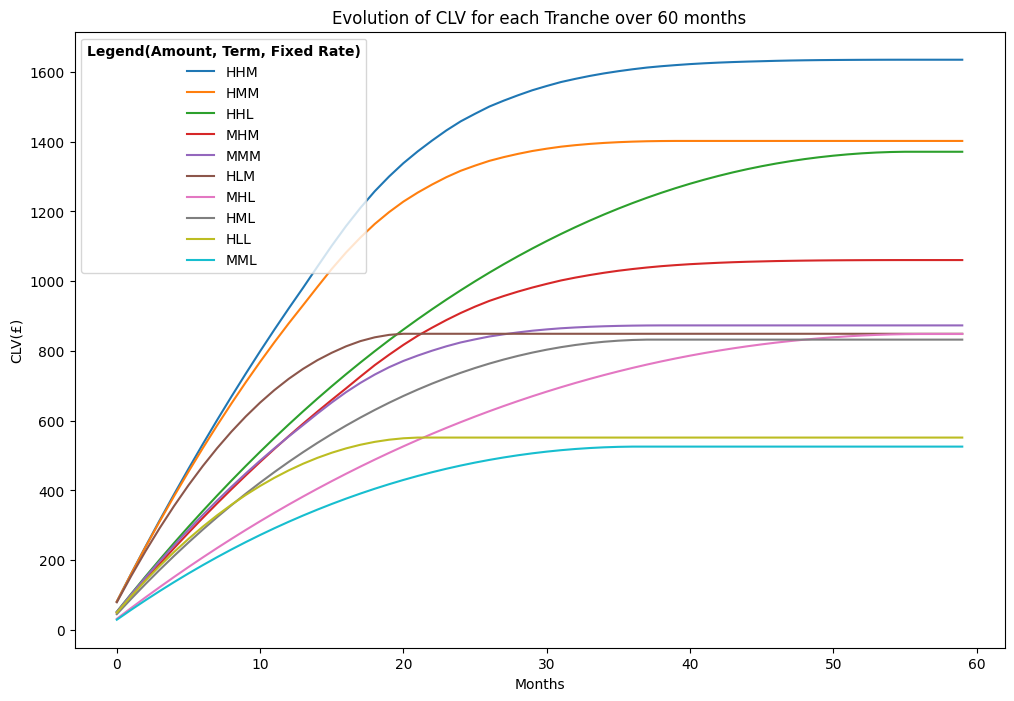

label         clv  survived_months  tranche_loan_tenure
  HHM 1635.000223           27.671                   56
  HMM 1402.127816           26.672                   40
  HHL 1371.100870           55.897                   56
  MHM 1060.555940           31.581                   56
  MMM  873.205252           26.328                   39
  HLM  849.200287           20.614                   21
  MHL  848.557868           56.727                   57
  HML  832.423392           38.000                   38
  HLL  551.582231           22.000                   22
  MML  525.660537           37.000                   37
  MLM  487.986909           19.670                   20
  LHM  428.115898           27.206                   55
  HHH  362.660962            1.038                   55
  HMH  357.267562            1.036                   40
  HLH  354.494639            1.035                   21
  LMM  344.895328           26.955                   39
  MLL  314.052108           20.000              

In [15]:
file_path = "data.xlsx"
ir_termS = pd.read_excel(file_path, sheet_name='interest_rate_term_structure')
cr_termS = pd.read_excel(file_path, sheet_name='credit_risk_term_structure')
ir_params = pd.read_excel(file_path, sheet_name='interest_rate_parameters')
cr_params = pd.read_excel(file_path, sheet_name='credit_risk_parameters')
ir_termS['rate'] += 0.001
ir_params['sigma'] *= 1.1
ssrd = generate_ssrd_model(ir_termS, cr_termS, ir_params, cr_params, ssrd_params)
funding_cost, risk_free_rate, credit_premia = simulate_funding_cost(ssrd, liquidity_risk_bps, risk_margin_bps)
clv_labels, trancheClvs, clv_for_excel = find_clv(loan_tranches, funding_cost, risk_free_rate, max_loan_tenure)
clv_tables.append(clv_for_excel)
clv_sheet_names.append('interest_yc_vol_increase')
plot_clv(clv_labels, trancheClvs, max_loan_tenure, top_tranche_clv_to_display, 'interest_yc_vol_increase');
display_clv(clv_for_excel)

### Under combined stress in vol and yield curve interest rate(decrease)

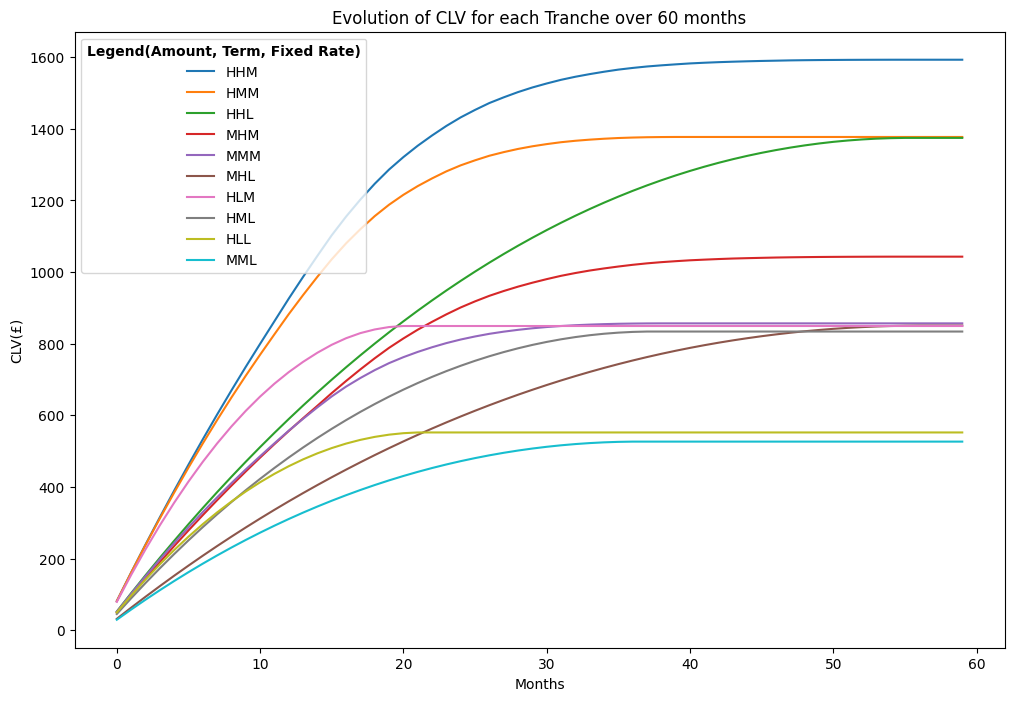

label         clv  survived_months  tranche_loan_tenure
  HHM 1593.027802           26.382                   56
  HMM 1377.333820           25.628                   40
  HHL 1374.722875           55.639                   56
  MHM 1043.108232           30.456                   56
  MMM  856.830639           25.238                   39
  MHL  850.602470           56.376                   57
  HLM  849.458425           20.347                   21
  HML  833.999211           38.000                   38
  HLL  552.218612           22.000                   22
  MML  526.631288           37.000                   37
  MLM  488.060790           19.408                   20
  LHM  417.435819           25.938                   55
  HHH  359.514519            1.006                   55
  HMH  354.371782            1.004                   40
  HLH  352.242095            1.003                   21
  LMM  339.695547           25.992                   39
  MLL  314.385503           20.000              

In [16]:
file_path = "data.xlsx"
ir_termS = pd.read_excel(file_path, sheet_name='interest_rate_term_structure')
cr_termS = pd.read_excel(file_path, sheet_name='credit_risk_term_structure')
ir_params = pd.read_excel(file_path, sheet_name='interest_rate_parameters')
cr_params = pd.read_excel(file_path, sheet_name='credit_risk_parameters')
ir_termS['rate'] -= 0.001
ir_params['sigma'] *= 0.9
ssrd = generate_ssrd_model(ir_termS, cr_termS, ir_params, cr_params, ssrd_params)
funding_cost, risk_free_rate, credit_premia = simulate_funding_cost(ssrd, liquidity_risk_bps, risk_margin_bps)
clv_labels, trancheClvs, clv_for_excel = find_clv(loan_tranches, funding_cost, risk_free_rate, max_loan_tenure)
clv_tables.append(clv_for_excel)
clv_sheet_names.append('interest_yc_vol_decrease')
plot_clv(clv_labels, trancheClvs, max_loan_tenure, top_tranche_clv_to_display, 'interest_yc_vol_decrease');
display_clv(clv_for_excel)

### Under combined stress in vol(increase) and yield curve(decrease) interest rate

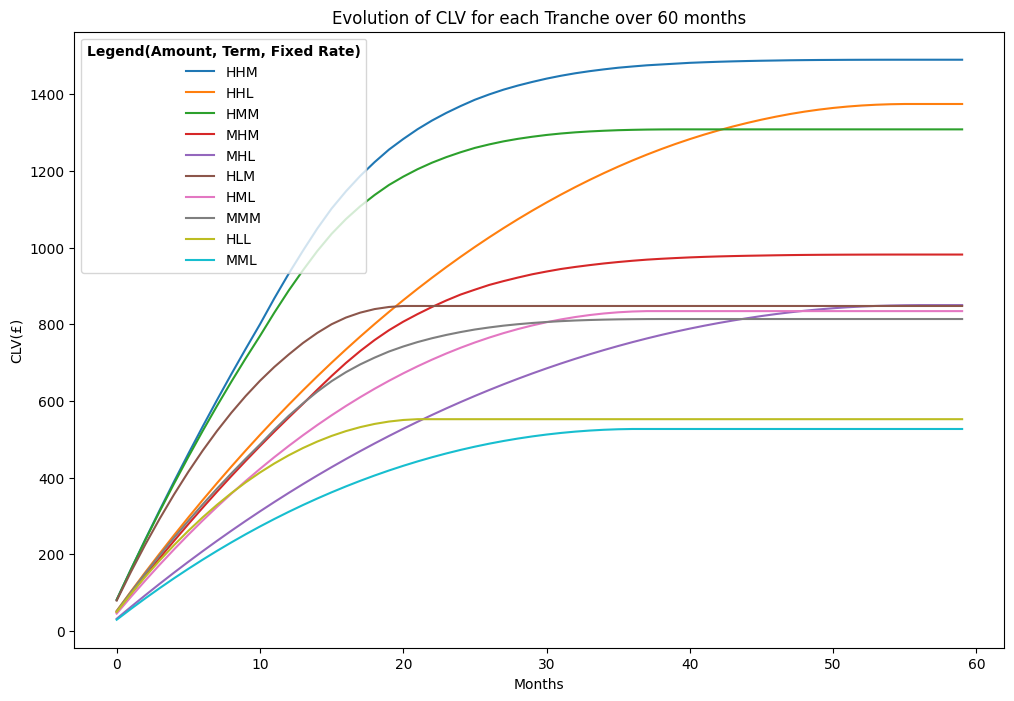

label         clv  survived_months  tranche_loan_tenure
  HHM 1489.710205           23.728                   56
  HHL 1374.257064           55.031                   56
  HMM 1308.073530           23.147                   40
  MHM  981.621687           27.424                   56
  MHL  849.796396           55.474                   57
  HLM  847.486429           19.657                   21
  HML  834.105095           38.000                   38
  MMM  813.477402           22.792                   39
  HLL  552.256376           22.000                   22
  MML  526.696490           37.000                   37
  MLM  487.284221           18.763                   20
  LHM  389.019456           23.245                   55
  HHH  360.927713            1.020                   55
  HMH  355.874530            1.020                   40
  HLH  353.127794            1.013                   21
  LMM  324.042794           23.590                   39
  MLL  314.404417           20.000              

In [17]:
file_path = "data.xlsx"
ir_termS = pd.read_excel(file_path, sheet_name='interest_rate_term_structure')
cr_termS = pd.read_excel(file_path, sheet_name='credit_risk_term_structure')
ir_params = pd.read_excel(file_path, sheet_name='interest_rate_parameters')
cr_params = pd.read_excel(file_path, sheet_name='credit_risk_parameters')
ir_termS['rate'] -= 0.001
ir_params['sigma'] *= 1.1
ssrd = generate_ssrd_model(ir_termS, cr_termS, ir_params, cr_params, ssrd_params)
funding_cost, risk_free_rate, credit_premia = simulate_funding_cost(ssrd, liquidity_risk_bps, risk_margin_bps)
clv_labels, trancheClvs, clv_for_excel = find_clv(loan_tranches, funding_cost, risk_free_rate, max_loan_tenure)
clv_tables.append(clv_for_excel)
clv_sheet_names.append('interest_yc_dec_vol_inc')
plot_clv(clv_labels, trancheClvs, max_loan_tenure, top_tranche_clv_to_display, 'interest_yc_dec_vol_inc');
display_clv(clv_for_excel)

### Under combined stress in vol(decrease) and yield curve(increase) interest rate

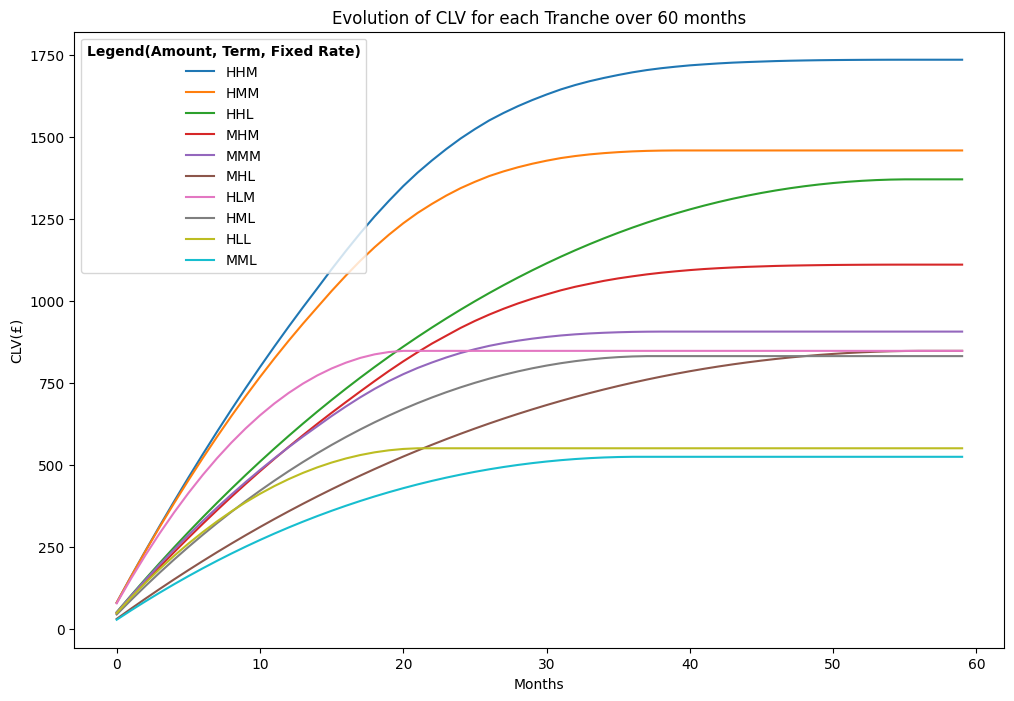

label         clv  survived_months  tranche_loan_tenure
  HHM 1735.198897           30.692                   56
  HMM 1458.780614           29.335                   40
  HHL 1370.773853           55.985                   56
  MHM 1110.990236           34.553                   56
  MMM  906.992714           28.916                   39
  MHL  848.361961           56.932                   57
  HLM  848.283867           20.870                   21
  HML  832.318106           38.000                   38
  HLL  551.544627           22.000                   22
  MML  525.595697           37.000                   37
  MLM  487.316786           19.897                   20
  LHM  454.187662           30.146                   55
  HHH  360.000927            1.011                   55
  LMM  357.825603           29.581                   39
  HMH  355.020964            1.011                   40
  HLH  352.513935            1.007                   21
  MLL  314.033272           20.000              

In [18]:
file_path = "data.xlsx"
ir_termS = pd.read_excel(file_path, sheet_name='interest_rate_term_structure')
cr_termS = pd.read_excel(file_path, sheet_name='credit_risk_term_structure')
ir_params = pd.read_excel(file_path, sheet_name='interest_rate_parameters')
cr_params = pd.read_excel(file_path, sheet_name='credit_risk_parameters')
ir_termS['rate'] += 0.001
ir_params['sigma'] *= 0.9
ssrd = generate_ssrd_model(ir_termS, cr_termS, ir_params, cr_params, ssrd_params)
funding_cost, risk_free_rate, credit_premia = simulate_funding_cost(ssrd, liquidity_risk_bps, risk_margin_bps)
clv_labels, trancheClvs, clv_for_excel = find_clv(loan_tranches, funding_cost, risk_free_rate, max_loan_tenure)
clv_tables.append(clv_for_excel)
clv_sheet_names.append('interest_yc_inc_vol_dec')
plot_clv(clv_labels, trancheClvs, max_loan_tenure, top_tranche_clv_to_display, 'interest_yc_inc_vol_dec');
display_clv(clv_for_excel)

### Under zero liquidity risk

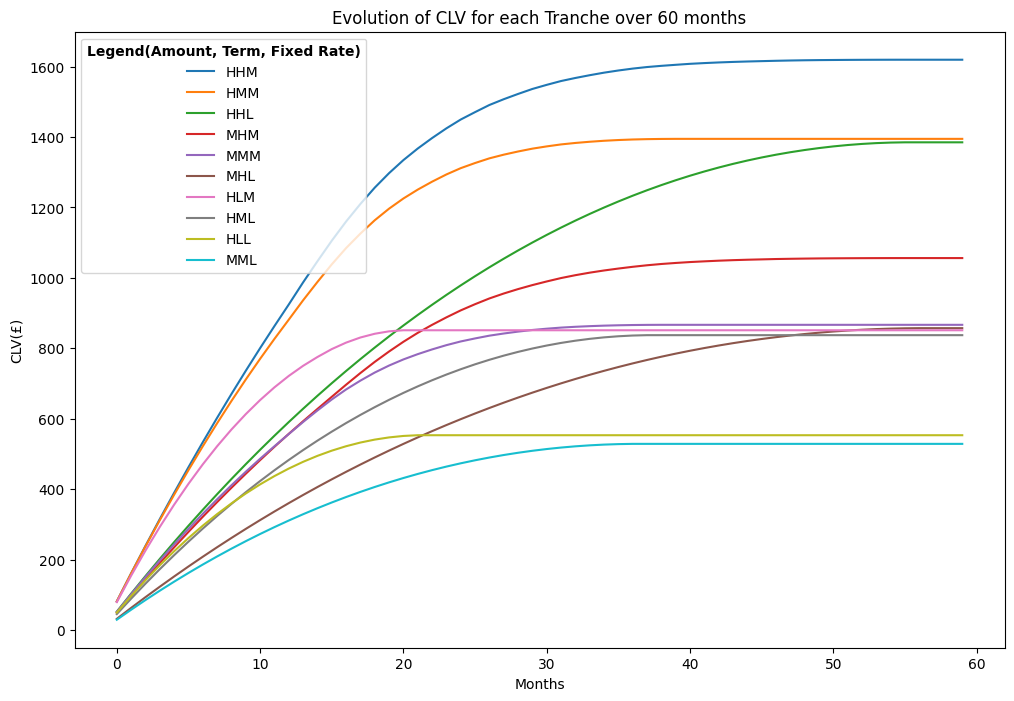

label         clv  survived_months  tranche_loan_tenure
  HHM 1619.543751           26.941                   56
  HMM 1394.819452           26.118                   40
  HHL 1384.986726           55.758                   56
  MHM 1056.279704           30.937                   56
  MMM  866.726531           25.672                   39
  MHL  857.253489           56.512                   57
  HLM  851.291479           20.473                   21
  HML  837.352040           38.000                   38
  HLL  553.225248           22.000                   22
  MML  528.664555           37.000                   37
  MLM  489.248623           19.540                   20
  LHM  423.927376           26.472                   55
  HHH  360.215403            1.012                   55
  HMH  355.230076            1.012                   40
  HLH  352.976299            1.011                   21
  LMM  344.091973           26.580                   39
  MLL  314.889317           20.000              

In [19]:
file_path = "data.xlsx"
ir_termS = pd.read_excel(file_path, sheet_name='interest_rate_term_structure')
cr_termS = pd.read_excel(file_path, sheet_name='credit_risk_term_structure')
ir_params = pd.read_excel(file_path, sheet_name='interest_rate_parameters')
cr_params = pd.read_excel(file_path, sheet_name='credit_risk_parameters')
ssrd = generate_ssrd_model(ir_termS, cr_termS, ir_params, cr_params, ssrd_params)
funding_cost, risk_free_rate, credit_premia = simulate_funding_cost(ssrd, 0, risk_margin_bps)
clv_labels, trancheClvs, clv_for_excel = find_clv(loan_tranches, funding_cost, risk_free_rate, max_loan_tenure)
clv_tables.append(clv_for_excel)
clv_sheet_names.append('zero_liquidity_risk')
plot_clv(clv_labels, trancheClvs, max_loan_tenure, top_tranche_clv_to_display, 'zero_liquidity_risk');
display_clv(clv_for_excel)

### Under survivourship sigmoid slope 4(75 degree)

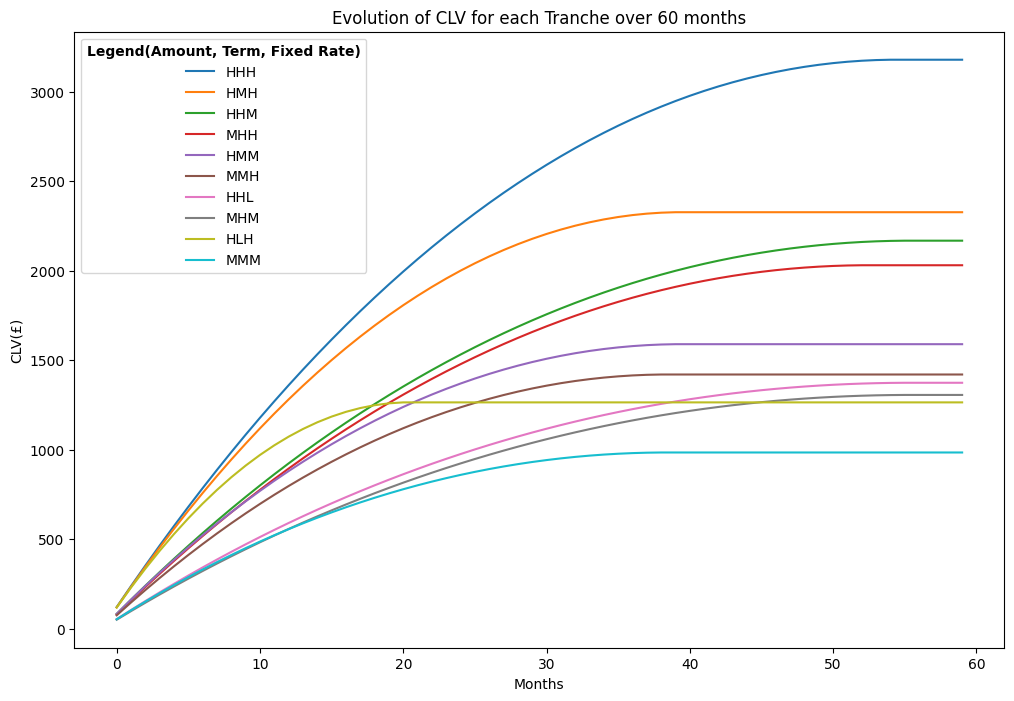

label         clv  survived_months  tranche_loan_tenure
  HHH 3177.620668             55.0                   55
  HMH 2325.711429             40.0                   40
  HHM 2166.680997             56.0                   56
  MHH 2029.411814             53.0                   53
  HMM 1588.408323             40.0                   40
  MMH 1419.030548             39.0                   39
  HHL 1372.835364             56.0                   56
  MHM 1304.868565             56.0                   56
  HLH 1263.292585             21.0                   21
  MMM  983.401637             39.0                   39
  MHL  849.648634             57.0                   57
  HLM  847.864796             21.0                   21
  HML  833.207195             38.0                   38
  LHH  797.325172             54.0                   54
  MLH  762.565960             20.0                   20
  LMH  570.952207             38.0                   38
  LHM  567.411681             55.0              

In [20]:
file_path = "data.xlsx"
ir_termS = pd.read_excel(file_path, sheet_name='interest_rate_term_structure')
cr_termS = pd.read_excel(file_path, sheet_name='credit_risk_term_structure')
ir_params = pd.read_excel(file_path, sheet_name='interest_rate_parameters')
cr_params = pd.read_excel(file_path, sheet_name='credit_risk_parameters')
ssrd = generate_ssrd_model(ir_termS, cr_termS, ir_params, cr_params, ssrd_params)
funding_cost, risk_free_rate, credit_premia = simulate_funding_cost(ssrd, liquidity_risk_bps, risk_margin_bps)
clv_labels, trancheClvs, clv_for_excel = find_clv(loan_tranches, funding_cost, risk_free_rate, max_loan_tenure, 4)
clv_tables.append(clv_for_excel)
clv_sheet_names.append('4_sigmoid_survivourship_75')
plot_clv(clv_labels, trancheClvs, max_loan_tenure, top_tranche_clv_to_display, '4_sigmoid_survivourship_75');
display_clv(clv_for_excel)

### Under survivourship sigmoid slope 25(80.7 degree)

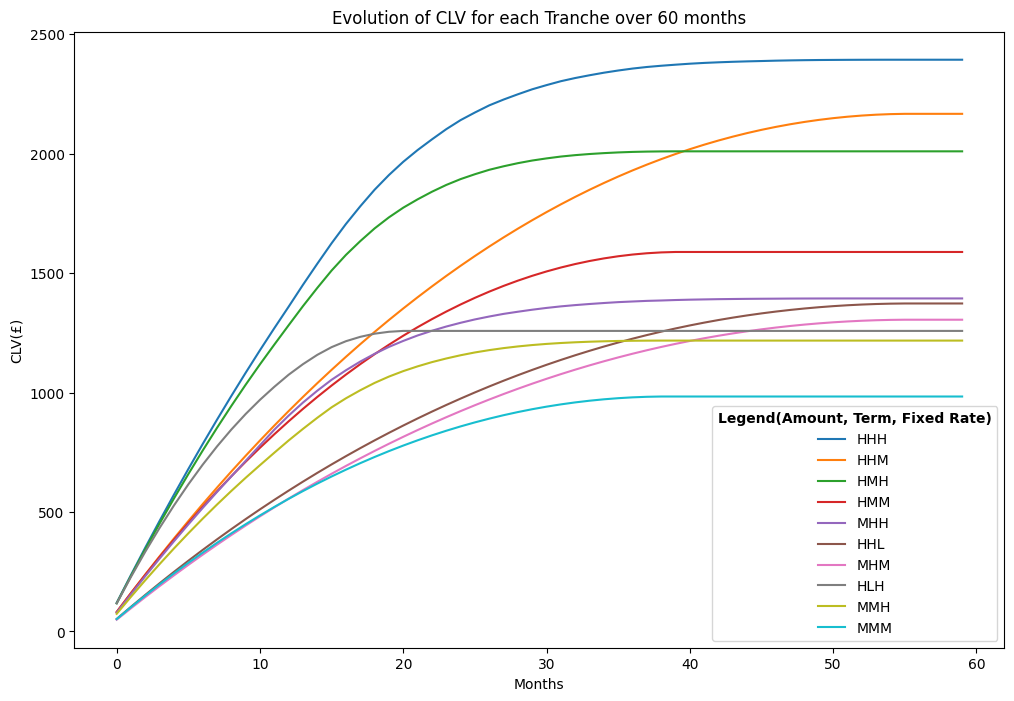

label         clv  survived_months  tranche_loan_tenure
  HHH 2393.178368           27.259                   55
  HHM 2166.680997           56.000                   56
  HMH 2009.712364           25.593                   40
  HMM 1588.408323           40.000                   40
  MHH 1393.911150           22.701                   53
  HHL 1372.835364           56.000                   56
  MHM 1304.868565           56.000                   56
  HLH 1258.006507           19.355                   21
  MMH 1217.487363           24.601                   39
  MMM  983.401637           39.000                   39
  MHL  849.648634           57.000                   57
  HLM  847.864796           21.000                   21
  HML  833.207195           38.000                   38
  MLH  763.565825           19.213                   20
  LHH  599.722653           26.700                   54
  LHM  567.411681           55.000                   55
  HLL  551.899165           22.000              

In [21]:
file_path = "data.xlsx"
ir_termS = pd.read_excel(file_path, sheet_name='interest_rate_term_structure')
cr_termS = pd.read_excel(file_path, sheet_name='credit_risk_term_structure')
ir_params = pd.read_excel(file_path, sheet_name='interest_rate_parameters')
cr_params = pd.read_excel(file_path, sheet_name='credit_risk_parameters')
ssrd = generate_ssrd_model(ir_termS, cr_termS, ir_params, cr_params, ssrd_params)
funding_cost, risk_free_rate, credit_premia = simulate_funding_cost(ssrd, liquidity_risk_bps, risk_margin_bps)
clv_labels, trancheClvs, clv_for_excel = find_clv(loan_tranches, funding_cost, risk_free_rate, max_loan_tenure, 25)
clv_tables.append(clv_for_excel)
clv_sheet_names.append('25_sigmoid_survivourship_80.7')
plot_clv(clv_labels, trancheClvs, max_loan_tenure, top_tranche_clv_to_display, '25_sigmoid_survivourship_80.7');
display_clv(clv_for_excel)

In [22]:
write_clv_to_excel(clv_tables, clv_sheet_names)